# Whole Human Brain 10x RNA-seq gene expression data (part 2)

In this notebook we'll explore some of the gene expression and combine it with the cell metadata we showed in **part 1**.

You need to be either connected to the internet or connected to a cache that has the WHB data downloaded already and have already downloaded the example data via the getting started notebook to run this notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.current_manifest

'releases/20240330/manifest.json'

Create the expanded cell metadata as was done previously in the cluster annotation tutorial and part 1 of the 10X tutorial.

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))

# Load the cluster memembership metadata and combine the data with the cell data.
membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[term_sets['name']] # order columns
cluster_details.fillna('Other', inplace=True)

cluster_details.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[term_sets['name']]
cluster_colors.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors

roi = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='region_of_interest_structure_map')
roi.set_index('region_of_interest_label', inplace=True)
roi.rename(columns={'color_hex_triplet': 'region_of_interest_color'},
           inplace=True)

del membership
del term_sets

cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(roi[['region_of_interest_color']], on='region_of_interest_label')

del cluster_details
del cluster_colors
del roi

cell_extended.head(5)

Number of cells =  3369219


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,donor_label,donor_sex,dataset_label,...,anatomical_division_label,subcluster,cluster,supercluster,neurotransmitter,subcluster_color,cluster_color,supercluster_color,neurotransmitter_color,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
10X386_2:CATGGATTCTCGACGG,CATGGATTCTCGACGG,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X383_5:TCTTGCGGTGAATTGA,TCTTGCGGTGAATTGA,10X383_5,LKTX_210818_02_E01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.94,10Xv3,H19.30.002,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X386_2:CTCATCGGTCGAGCAA,CTCATCGGTCGAGCAA,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_17,URL_312,Upper rhombic lip,VGLUT1,#C85E40,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X378_8:TTGGATGAGACAAGCC,TTGGATGAGACAAGCC,10X378_8,LKTX_210809_01_H01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.93,10Xv3,H19.30.002,M,WHB-10Xv3,...,Pons,URL_312_18,URL_312,Upper rhombic lip,VGLUT1,#61C1C2,#97B8C8,#80BAED,#2BDFD1,#517DBE
10X387_7:TGAACGTAGTATTCCG,TGAACGTAGTATTCCG,10X387_7,LKTX_210825_02_G01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_16,URL_312,Upper rhombic lip,VGLUT1,#45328F,#97B8C8,#80BAED,#2BDFD1,#5D6CB2


### Single cell transcriptomes

The ~3 million cell dataset of WHB has been divided into 2 expression matrices: one with Neurons and one with Nonneurons. Each matrix file is formatted as an annadata, h5ad file with minimal metadata. 

Below we show some interactions with data from the 10X expression matricies in the WHB dataset. For a deeper dive into how to access specific gene data from the expression matricies, take a look at ``general_acessing_10x_snRNASeq_tutorial.ipynb``. Below we will use precomputed metadata from these matricies to look at gene expression both in relation to different neurotransmitters and locations across the brain.

First, we list the available metadata in the WHB-10Xv3 dataset again. The two files we will be using in this tutorial are the ``gene`` metadata and the ``example_genes_all_cells_expression`` table.

In [4]:
abc_cache.list_metadata_files('WHB-10Xv3')

['anatomical_division_structure_map',
 'cell_metadata',
 'donor',
 'example_genes_all_cells_expression',
 'gene',
 'region_of_interest_structure_map']

The table below holds metadata for all genes sequenced in the dataset.

In [5]:
gene = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  59357


,gene_symbol,biotype,name
gene_identifier,,,
ENSG00000000003,TSPAN6,protein_coding,tetraspanin 6
ENSG00000000005,TNMD,protein_coding,tenomodulin
ENSG00000000419,DPM1,protein_coding,dolichyl-phosphate mannosyltransferase subunit...
ENSG00000000457,SCYL3,protein_coding,SCY1 like pseudokinase 3
ENSG00000000460,C1orf112,protein_coding,chromosome 1 open reading frame 112


We'll skip accessing these data from the expression matricies specifically for now, however, users can learn how to access specific genes from the released expression matricies in the``general_acessing_10x_snRNASeq_tutorial`` notebook.

The precomputed table below contains expressions for the genes *SLC17A6*, *SLC17A7*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, and *TTR* for all cells across the the WHB dataset. We then join this with our previously created, cell_extended pandas DataFrame from this tutorial.


In [6]:
example_cells_with_genes = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='example_genes_all_cells_expression'
).set_index('cell_label')
example_cells_with_genes.head()

,PTPRC,SLC17A6,SLC32A1,SLC17A7,TTR,PLP1,AQP4
cell_label,,,,,,,
10X386_2:CATGGATTCTCGACGG,0.0,0.0,0.0,0.000000,13.652457,0.000000,0.0
10X383_5:TCTTGCGGTGAATTGA,0.0,0.0,0.0,0.000000,10.484976,0.000000,0.0
10X386_2:CTCATCGGTCGAGCAA,0.0,0.0,0.0,0.000000,14.006844,0.000000,0.0
10X378_8:TTGGATGAGACAAGCC,0.0,0.0,0.0,9.348821,0.000000,9.348821,0.0
10X387_7:TGAACGTAGTATTCCG,0.0,0.0,0.0,0.000000,12.046448,0.000000,0.0


In [7]:
cell_extended_with_genes = cell_extended.join(example_cells_with_genes)

## Example use cases

In this section, we show a use case with the example genes *SLC17A6*, *SLC17A7*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, and *TTR*. These genes were selected because they were presented in [Siletti et al. 2023](https://www.science.org/doi/10.1126/science.add7046) as markers genes for glutamatergic (*SLC17A6*, *SLC17A7*) and GABAergic (*SLC32A1*) neurons, immune cells (*PTPRC*), oligodendrocytes (*PLP1*), astrocytes (*AQP4*), and choroid plexus (*TTR*).  "Marker genes" have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.  Additional context about these genes, and additional genes of interest can be found in [Siletti et al. 2023](https://www.science.org/doi/10.1126/science.add7046).

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

In [8]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of selected genes in the whole brain

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [9]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=6)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

Below, we plot the expression of the genes selected in seven genes. We show the genes vs neurotransmitter type/idendity. 

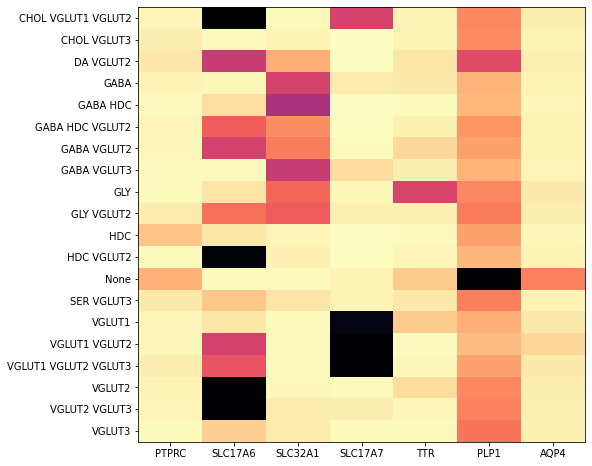

In [10]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'neurotransmitter')
res = plot_heatmap(agg, 8, 8)

Below is by dissection region of interest shows that each of these genes are associated with distinct regions.

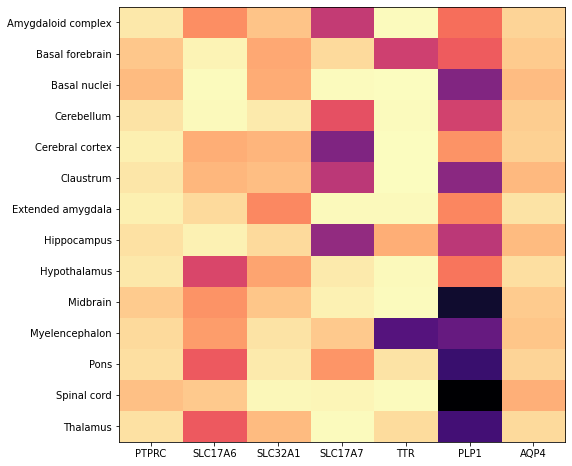

In [11]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'anatomical_division_label')
res = plot_heatmap(agg, 8, 8)

And finally by supercluster from the taxonomy.

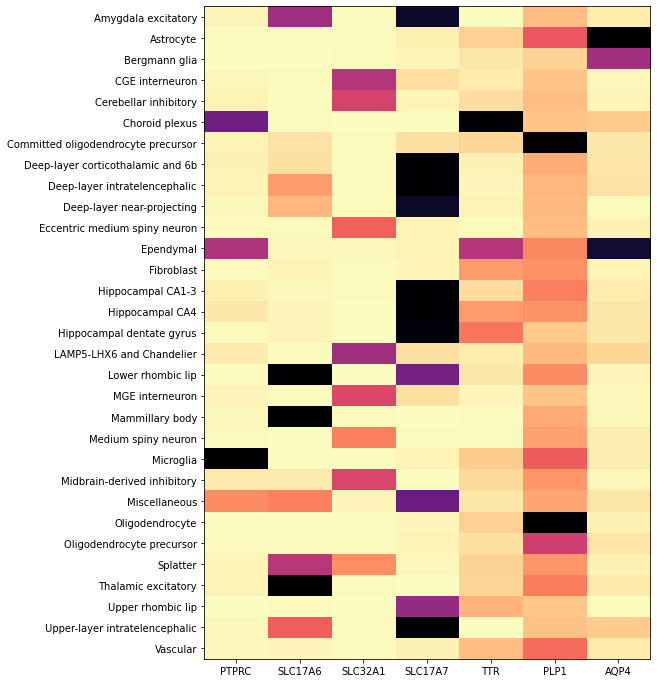

In [12]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'supercluster')
res = plot_heatmap(agg, 8, 12)

We can also visualize the relationship these genes and their location in the UMAP. Note again as in part one that Neurons and Non-neurons should be plotted seperately.

In [13]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [14]:
neurons_subsampled = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'WHB-10Xv3-Neurons'][::10]
non_neurons_subsampled = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'WHB-10Xv3-Nonneurons'][::10]

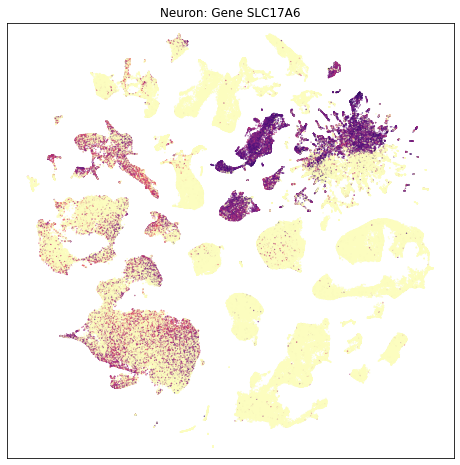

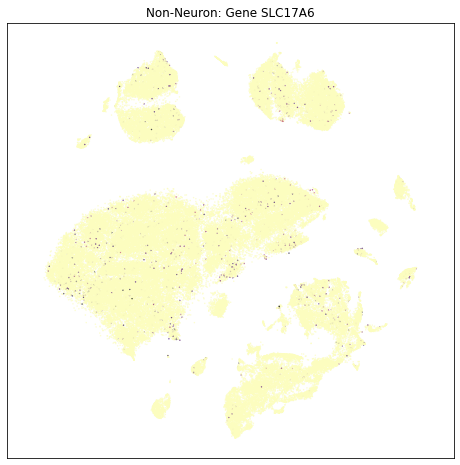

In [15]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['SLC17A6'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene SLC17A6")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['SLC17A6'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene SLC17A6")

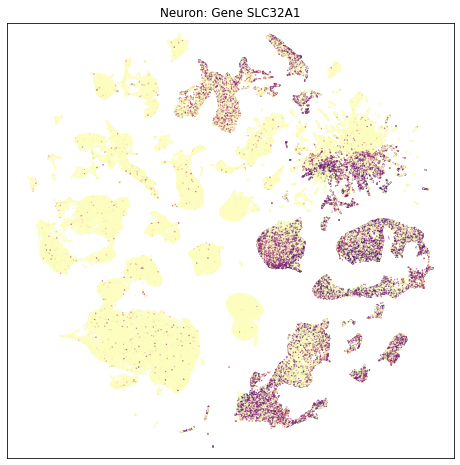

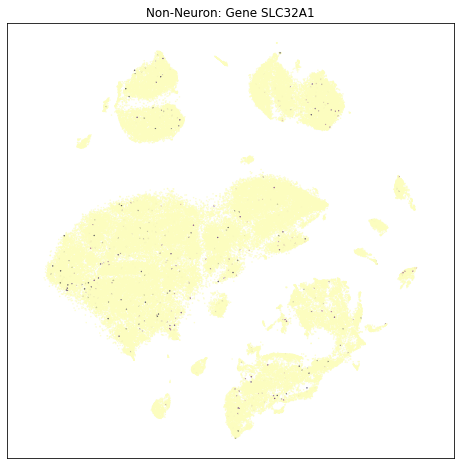

In [16]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['SLC32A1'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene SLC32A1")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['SLC32A1'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene SLC32A1")

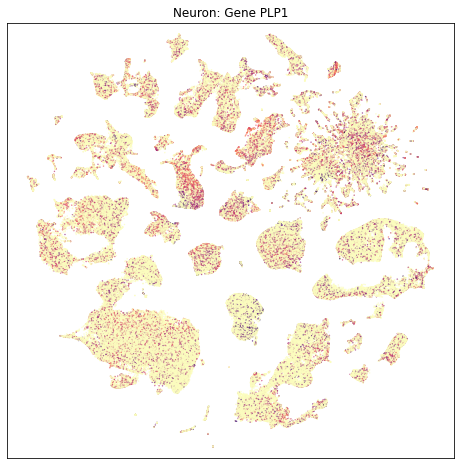

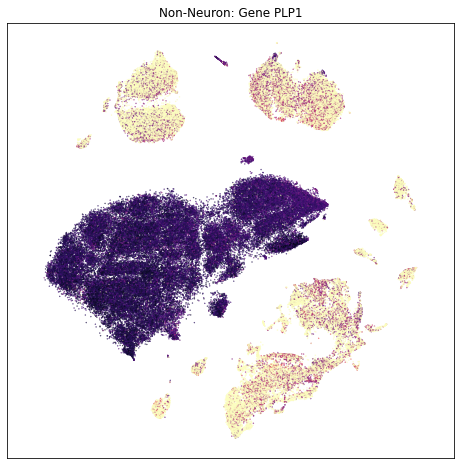

In [17]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['PLP1'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene PLP1")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['PLP1'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene PLP1")

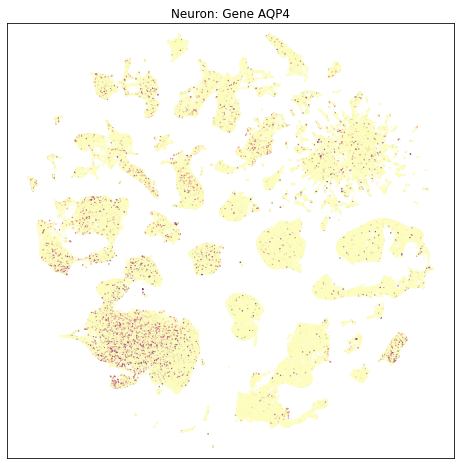

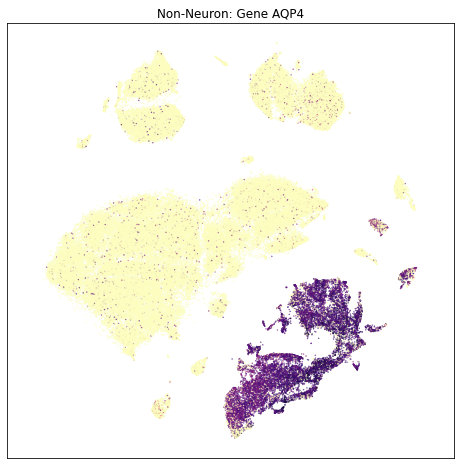

In [18]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['AQP4'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene AQP4")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['AQP4'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene AQP4")

(Plots for *SLC17A7*, *PTPRC*, and *TTR* could be generated the same way, but aren't shown.)